## Predictive Data Analysis Project


#### The Air Quality dataset from the UCI Machine Learning Repository discloses air quality monitoring information that can help us address environmental and health management concerns in Italian cities. Harmful pollutants like carbon monoxide and nitrogen oxides deteriorate air quality and in return climate change, acid rain, and ecosystems may feel a major negative impact. Poor air quality is often linked to respiratory and cardiovascular diseases especially for those living in urban populations due to constant exposure to elevated pollution. Emerging research suggests that exposure to pollutants during pregnancy or early childhood can produce intellectual impairment and for adults, prolonged exposure can contribute to neurodegenerative illnesses like Parkinson disease. Recognizing air pollution as a global issue and providing predicted models to a city can facilitate timely responses to mitigate future risks in other cities for safeguarding public health and environmental management.



#### The Air Quality dataset consists of 15 independent features out of which 13 represent numerical data of hourly averaged response to air pollutants in an Italian city. Specifically, Carbon Monoxide (CO), Non-Methanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx), and Nitrogen Dioxide (NO2) were used to measure air quality, please refer to Table 1. The target feature is temperature (measured in Celsius), as it affects how pollution forms, spreads, and how much energy is being used. This dataset provides rich features for a regression-based problem to predict pollutant concentrations in air quality levels. However, among the 9,358 observations recorded between March 2004 to February 2005, some values are missing and marked as –200 due to sensor drift, device sensitivities, or biases for being the longest available study on-field. Therefore, this project proposed to clean the dataset and develop a machine learning (ML) model to estimate the temperature based on various air pollutants and gas multisensory device for developing predicted models to assess and manage air quality.





#### The main objective of this project is to implement a comprehensive machine learning pipeline for predicting temperature (y) using air quality sensor data. This workflow includes data ingestion, preprocessing, feature engineering, model selection, hyperparameter tuning, and evaluation. The goal is to leverage sensor responses and other atmospheric variables to build an accurate and robust predictive model.

### Importing Important Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from copy import deepcopy
from scipy import stats
import joblib

import warnings
warnings.filterwarnings("ignore")

plt.style.use("tableau-colorblind10")

Mounted at /content/drive


### 1. Data Reading

Dataset: https://archive.ics.uci.edu/dataset/360/air+quality

In [2]:
df = pd.read_csv("AirQualityUCI.csv", delimiter=";", ).iloc[:, :-2]
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


### Replacing commas (',') with periods ('.') in the dataset to handle decimal separator format issues.
### This ensures that values like '3,14' are correctly interpreted as '3.14' for numeric conversion.


In [3]:
df[["CO(GT)", "C6H6(GT)", "T", "RH", "AH"]] = df[["CO(GT)", "C6H6(GT)", "T", "RH", "AH"]].apply(
    lambda x: pd.to_numeric(x.str.replace(',', '.'), errors='coerce')
)

In [4]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


### Unimportant columns to remove

In [5]:
df.drop(["Date", "Time"], axis=1, inplace=True)

### 2.Data Cleaning

In [6]:
print("Dataset Shape:",df.shape)

Dataset Shape: (9471, 13)


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9357 non-null   float64
 1   PT08.S1(CO)    9357 non-null   float64
 2   NMHC(GT)       9357 non-null   float64
 3   C6H6(GT)       9357 non-null   float64
 4   PT08.S2(NMHC)  9357 non-null   float64
 5   NOx(GT)        9357 non-null   float64
 6   PT08.S3(NOx)   9357 non-null   float64
 7   NO2(GT)        9357 non-null   float64
 8   PT08.S4(NO2)   9357 non-null   float64
 9   PT08.S5(O3)    9357 non-null   float64
 10  T              9357 non-null   float64
 11  RH             9357 non-null   float64
 12  AH             9357 non-null   float64
dtypes: float64(13)
memory usage: 962.0 KB
None


### 2.1. Checking the Missing Values

In [8]:
print("Checking Missing Values")
df.isna().sum()

Checking Missing Values


,0
CO(GT),114
PT08.S1(CO),114
NMHC(GT),114
C6H6(GT),114
PT08.S2(NMHC),114
NOx(GT),114
PT08.S3(NOx),114
NO2(GT),114
PT08.S4(NO2),114
PT08.S5(O3),114


In [9]:
print("Checking the dataset shape after dropping the missing values rows:", df.dropna(axis=0).shape)


Checking the dataset shape after dropping the missing values rows: (9357, 13)


#### Observation: This means that, there are 114 rows ,where all the columns are having missing values
    -> Since, all the values are missing in the rows, it is best choice to drop the rows

In [10]:
df.dropna(inplace=True, axis=0)

In [11]:
print("After dropping all the rows with missing values, checking if there are any other missing values remaining or not: ")
df.isna().sum()

After dropping all the rows with missing values, checking if there are any other missing values remaining or not: 


,0
CO(GT),0
PT08.S1(CO),0
NMHC(GT),0
C6H6(GT),0
PT08.S2(NMHC),0
NOx(GT),0
PT08.S3(NOx),0
NO2(GT),0
PT08.S4(NO2),0
PT08.S5(O3),0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9357 non-null   float64
 1   PT08.S1(CO)    9357 non-null   float64
 2   NMHC(GT)       9357 non-null   float64
 3   C6H6(GT)       9357 non-null   float64
 4   PT08.S2(NMHC)  9357 non-null   float64
 5   NOx(GT)        9357 non-null   float64
 6   PT08.S3(NOx)   9357 non-null   float64
 7   NO2(GT)        9357 non-null   float64
 8   PT08.S4(NO2)   9357 non-null   float64
 9   PT08.S5(O3)    9357 non-null   float64
 10  T              9357 non-null   float64
 11  RH             9357 non-null   float64
 12  AH             9357 non-null   float64
dtypes: float64(13)
memory usage: 1023.4 KB


### Sepaarating Independent and Dependent columns

In [13]:
X, y = df.drop(["T"], axis=1), df["T"]


### 2.2. The Descriptive Statisitcal Description of the data

In [14]:
print("Checking the Statistical Parameters of all the columns:")
X.describe()

Checking the Statistical Parameters of all the columns:


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,88.700000,2.231000


### Observation: Here we can see that, in all the columns, there are negative values, which is also the minimul values of all the columns.
 ###   - All the columns related to pollutant concentrations in your dataset should logically contain non-negative values.
 ###   - also they are far away from their respective Medians.
 ###   - We can consider them as `Missing data` or some `erorrs in data collection`.
<br >
<h3> -> Also it is also mentioned in the dataset description that: "Missing values are tagged with -200 value."
<br>

### Let's see each columm is containing what percentage of Negative Values

In [15]:
# Percentage of Negative Values

negative_counts = (X< 0).sum()  / X.shape[0] * 100
print(negative_counts)

CO(GT)           17.986534
PT08.S1(CO)       3.911510
NMHC(GT)         90.231912
C6H6(GT)          3.911510
PT08.S2(NMHC)     3.911510
NOx(GT)          17.516298
PT08.S3(NOx)      3.911510
NO2(GT)          17.548360
PT08.S4(NO2)      3.911510
PT08.S5(O3)       3.911510
RH                3.911510
AH                3.911510
dtype: float64


### Handling the scenario of `Missing data` or some `erorrs in data collection`

### -> Here we can Observe that, column `NMHC(GT)` is containing `90.23% of negative values`, so it is good idea to drop the is column
### -> On the other hand, for the remaining columns, we can do Statistical Imputation in the place those negetive values by estimating the approximate values, which should be there seeing the nearest neighbour points, using `K-Nearest Neighbours Impputer`.

In [16]:
# dropping column having 90.23% missing values
X.drop(columns=["NMHC(GT)"], inplace=True)

In [17]:
def impute_negative_values(data, value_to_impute=-200, n_neighbors=5):
    """
    Imputes specified values in the continuous columns of the dataset using KNN Imputer.

    Parameters:
    data (pd.DataFrame): The input dataset with numeric features.
    value_to_impute (float): The value to impute (default is -200).
    n_neighbors (int): The number of neighbors to use for imputation (default is 5).

    Returns:
    pd.DataFrame: The dataset with the specified values imputed in continuous columns.
    """
    # Create a copy of the DataFrame to avoid modifying the original data
    data_copy = deepcopy(data)

    # Identify continuous columns (float and int)
    continuous_cols = data_copy.select_dtypes(include=['float64', 'int64']).columns

    # Replace the specified value with NaN in the continuous columns only
    data_copy[continuous_cols] = data_copy[continuous_cols].replace(value_to_impute, None)

    # Initialize the KNN Imputer
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)

    # Impute the missing values in continuous columns
    imputed_data = knn_imputer.fit_transform(data_copy[continuous_cols])

    # Update the continuous columns in the original DataFrame with the imputed values
    data_copy[continuous_cols] = imputed_data

    return data_copy

In [18]:
X = impute_negative_values(X)
X

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,48.9,0.7578
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,47.7,0.7255
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,54.0,0.7502
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,60.0,0.7867
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,29.3,0.7568
9353,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,23.7,0.7119
9354,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,18.3,0.6406
9355,2.1,1003.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,13.5,0.5139


### Outlier Detection using Isolation Forest

In [19]:
def detect_outliers_isolation_forest(data, contamination=0.05):
    """
    Detects outliers in the given dataset using Isolation Forest and returns their indexes.

    Parameters:
    data (pd.DataFrame): The input dataset with numeric features.
    contamination (float): The proportion of outliers in the data (default is 0.05).

    Returns:
    pd.Index: The indexes of the outlier data points in the original DataFrame.
    """
    # Ensure the input DataFrame contains only numeric columns
    numeric_data = data.select_dtypes(include=['float64', 'int64'])

    # Initialize Isolation Forest
    iso_forest = IsolationForest(contamination=contamination, random_state=42)

    # Fit the model and predict outliers
    outlier_predictions = iso_forest.fit_predict(numeric_data)

    # Get the indexes of the outliers (where prediction is -1)
    outlier_indexes = data.index[outlier_predictions == -1]

    return outlier_indexes

In [20]:
outliers_indexes = detect_outliers_isolation_forest(X)

print(f"In the dataset total percentage of outliers from the entire dataset is {round( outliers_indexes.shape[0] / X.shape[0] * 100 , 2) }%")

In the dataset total percentage of outliers from the entire dataset is 5.0%


### Observation: We can see that, there are 5% data points which are detected as outliers. As this is small portion of the dataset we can drop the those data points.

In [21]:
# Dropping the rows with outliers

X = X.drop(index=outliers_indexes)
y = y.drop(index=outliers_indexes)


### 1.2 Data Vizualization

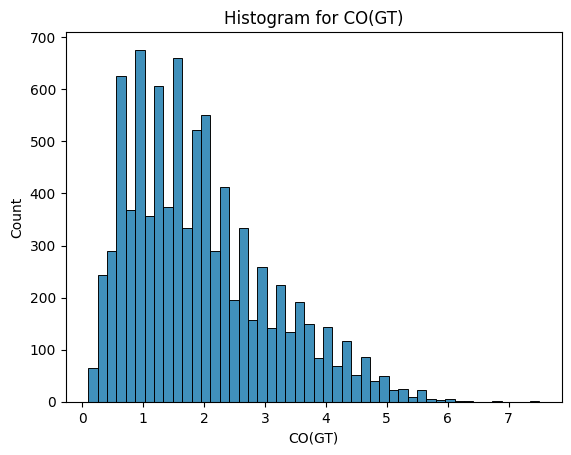

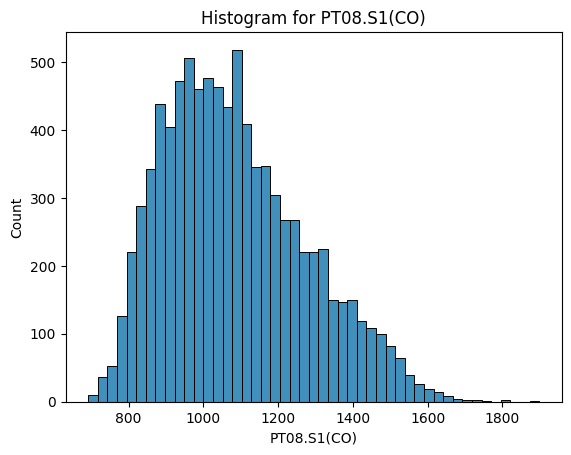

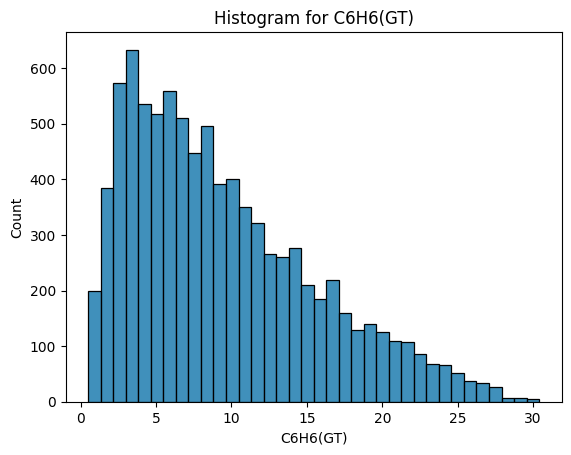

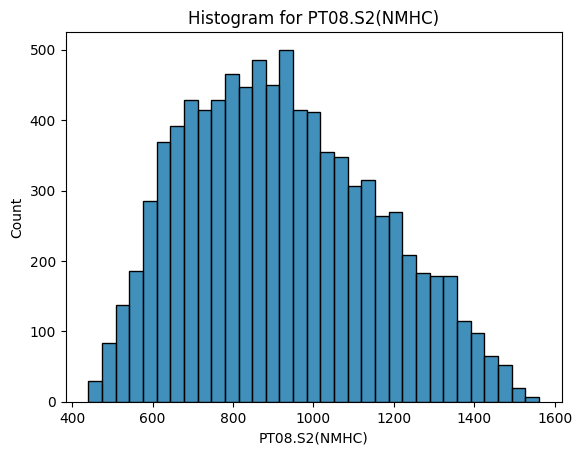

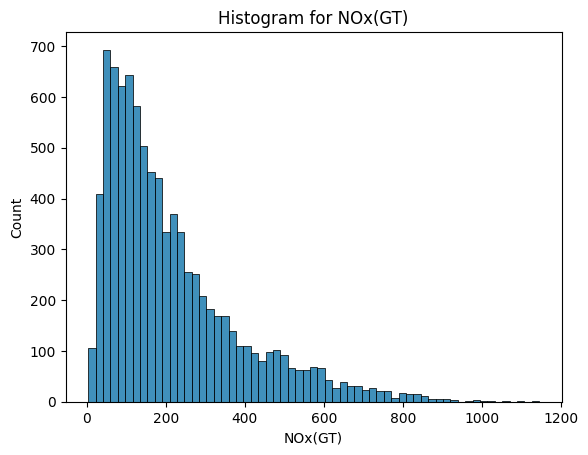

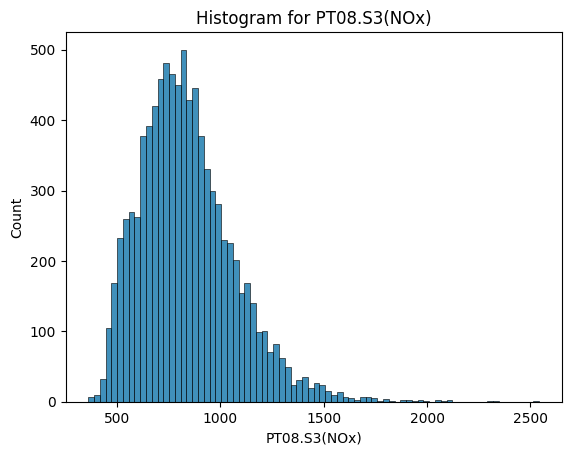

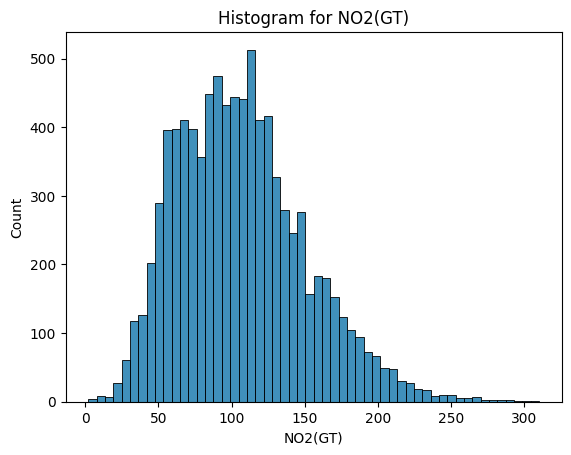

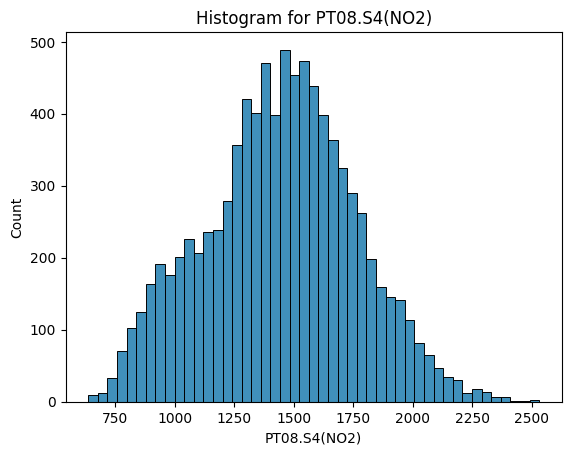

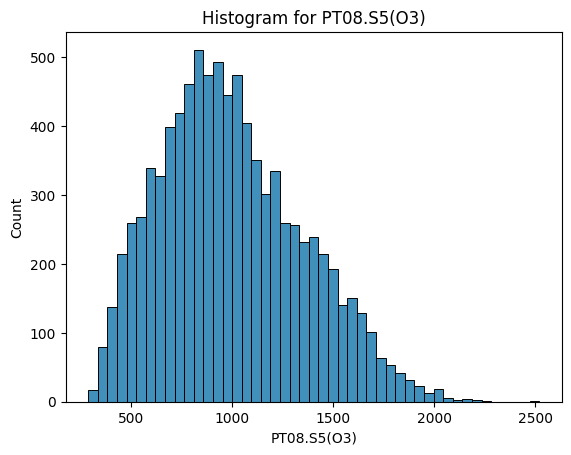

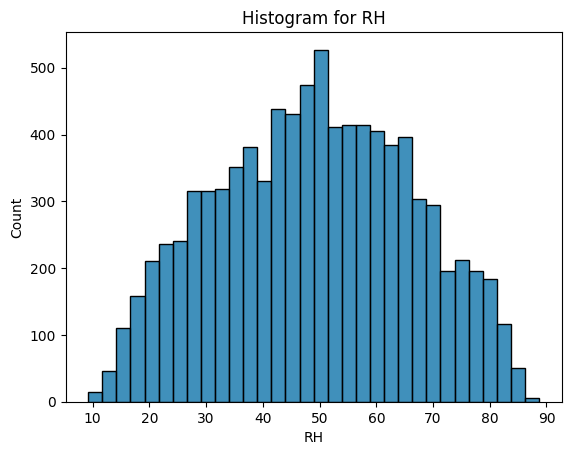

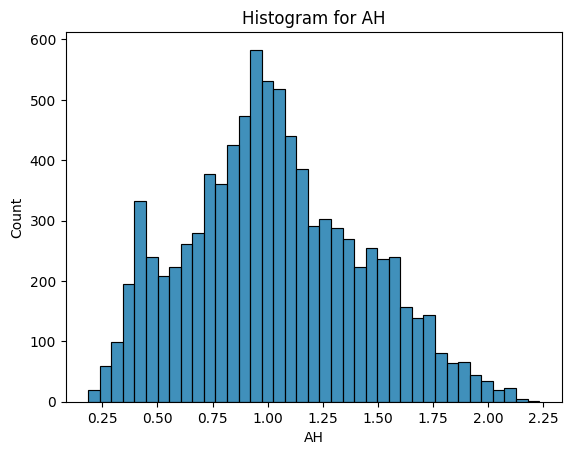

In [22]:
# Checking the Histogram of the continuous columns with the KDE: Kernal Density Estimation

for column in X.columns:
    plt.title(f"Histogram for {column}")
    sns.histplot(X[column])
    plt.show()

### -> Here we can see that many of the columns are positively skewed like: PT08.S1(CO), NOx(GT), PT08.S3(NOx) and more

### Feature Scaling

### Since we observed that, there are many polsitively skewed columns, we can use `Box-Cox transformation`, which is efficient `to handle positively skewed data` efficiently.

In [23]:
def boxcox_transform(df):
    """
    Apply Box-Cox transformation to all continuous columns in the DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame with numeric features.

    Returns:
    pd.DataFrame: A DataFrame with Box-Cox transformed values for continuous columns.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    transformed_df = deepcopy(df)

    # Identify continuous columns (float or int types)
    continuous_cols = transformed_df.select_dtypes(include=['float64', 'int64']).columns

    # Apply Box-Cox transformation to each continuous column
    for col in continuous_cols:
        # Check if all values are positive, as Box-Cox requires positive values
        if (transformed_df[col] <= 0).any():
            print(f"Cannot apply Box-Cox transformation to column '{col}' due to non-positive values.")
            continue

        # Apply Box-Cox transformation
        transformed_df[col], _ = stats.boxcox(transformed_df[col])

    return transformed_df

In [24]:
X = boxcox_transform(X)

### Re-observing the distribution plots of the features after applying the transformation

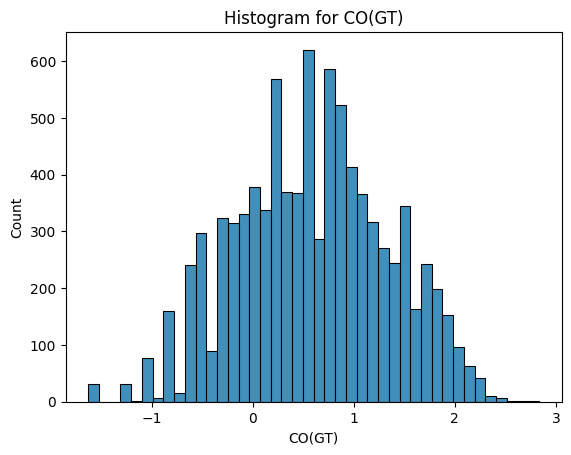

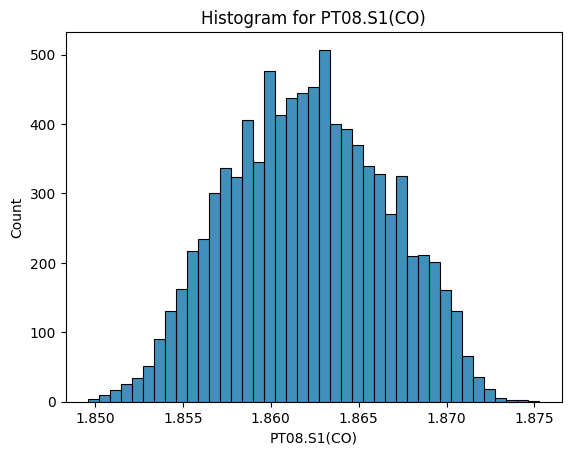

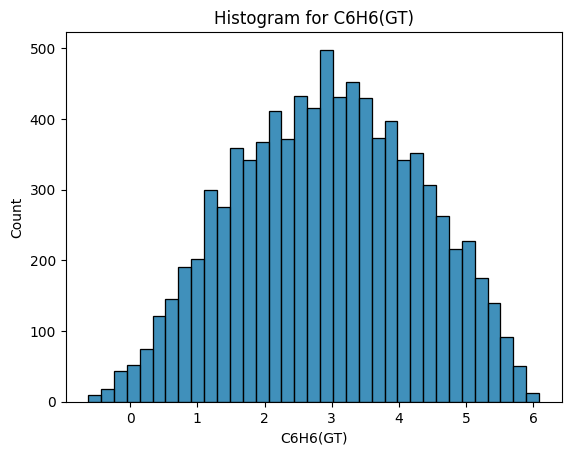

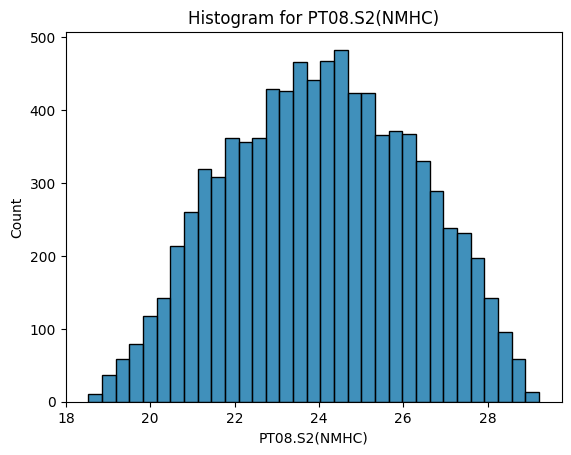

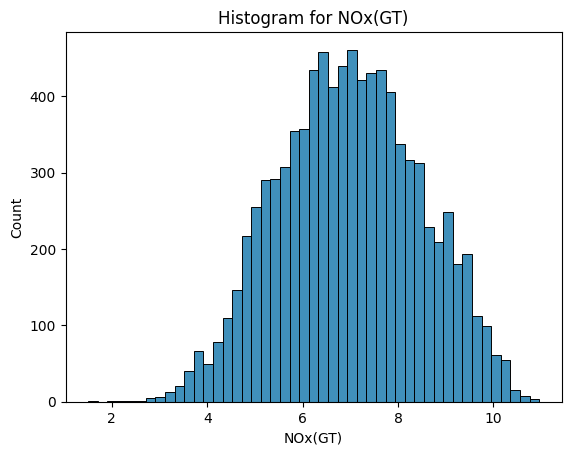

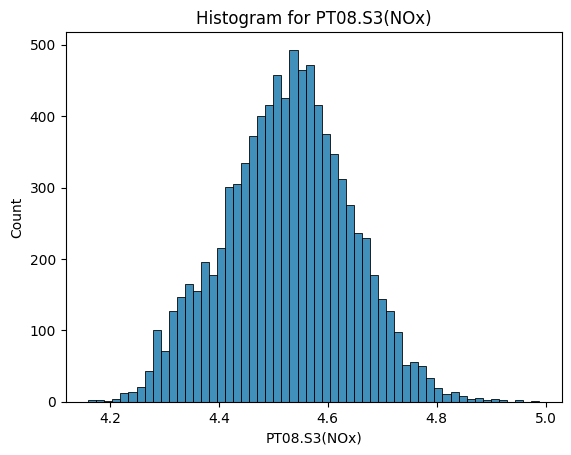

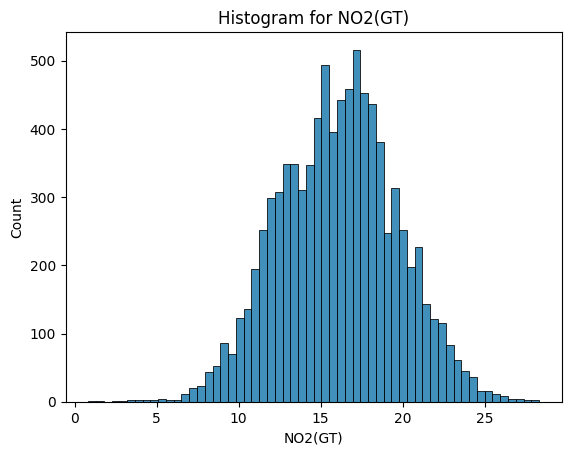

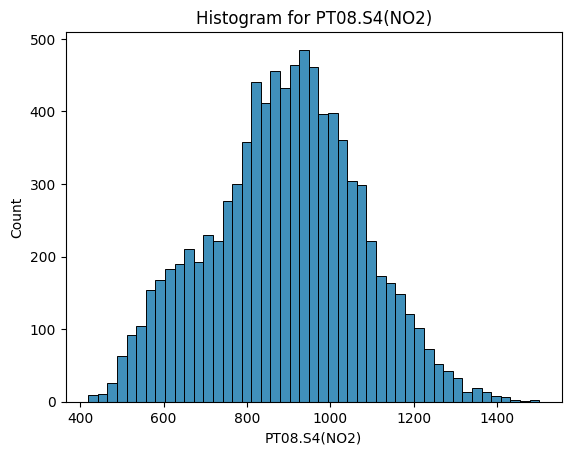

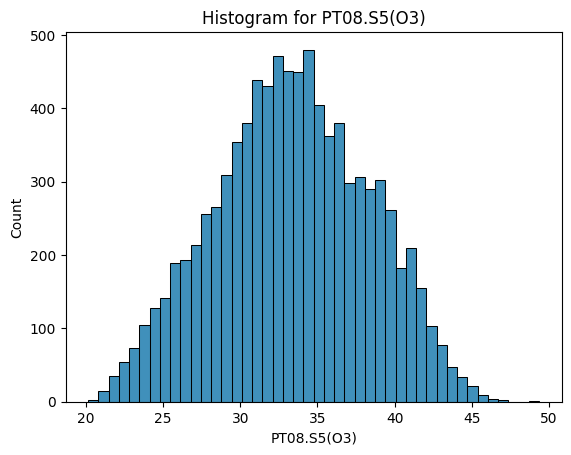

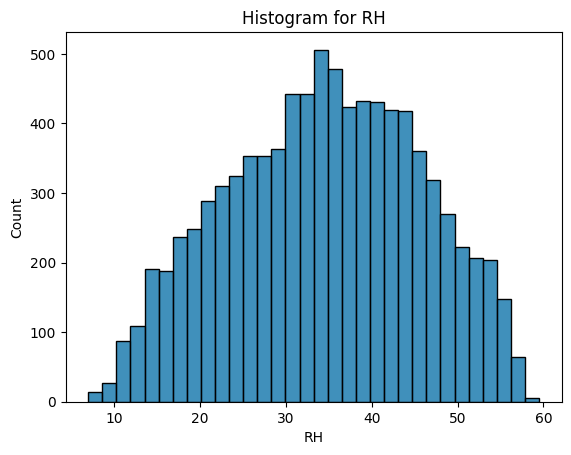

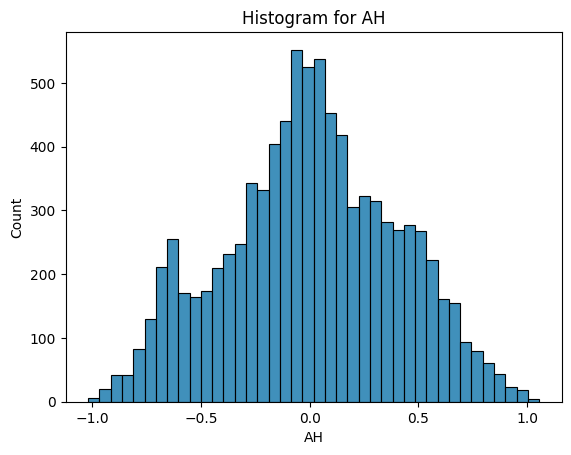

In [25]:
# Checking the Histogram of the continuous columns with the KDE: Kernal Density Estimation

for column in X.columns:
    plt.title(f"Histogram for {column}")
    sns.histplot(X[column])
    plt.show()

### Here we can observe that, `Box-cox transformation` has handled the skewed data efficiently, and now the distribution of all the columns are almost near to `Normal Distribution`.

### -> Now we have scaled the data

In [26]:
X

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH
0,1.118434,1.868235,3.731392,25.368674,7.006184,4.640865,16.987480,1034.422234,37.391550,34.588100,-0.253617
1,0.776402,1.867041,3.240003,24.558627,6.160104,4.684751,15.256340,959.044163,33.533168,33.807964,-0.289431
2,0.897332,1.868928,3.153266,24.410806,6.580475,4.672634,17.065392,956.769697,34.935839,37.880653,-0.261996
3,0.897332,1.868503,3.196959,24.494165,7.071046,4.654817,17.675845,973.249471,36.596423,41.710450,-0.222018
4,0.507350,1.866671,2.540117,23.415422,6.580475,4.695459,17.220117,919.745730,35.411134,41.456501,-0.219738
...,...,...,...,...,...,...,...,...,...,...,...
9352,1.364422,1.867437,4.009434,25.835127,9.032993,4.348196,22.168627,853.359384,42.415664,21.526148,-0.254718
9353,1.011013,1.864489,3.639246,25.203644,8.444346,4.399499,21.509088,790.008043,37.403583,17.633651,-0.304675
9354,1.011013,1.864032,3.820909,25.514604,8.077300,4.398758,21.263853,776.709422,35.174698,13.781512,-0.386307
9355,0.837844,1.860652,3.261288,24.613623,7.652950,4.466135,20.055474,660.225947,30.459067,10.249485,-0.539628


### Feature Selection

<Axes: >

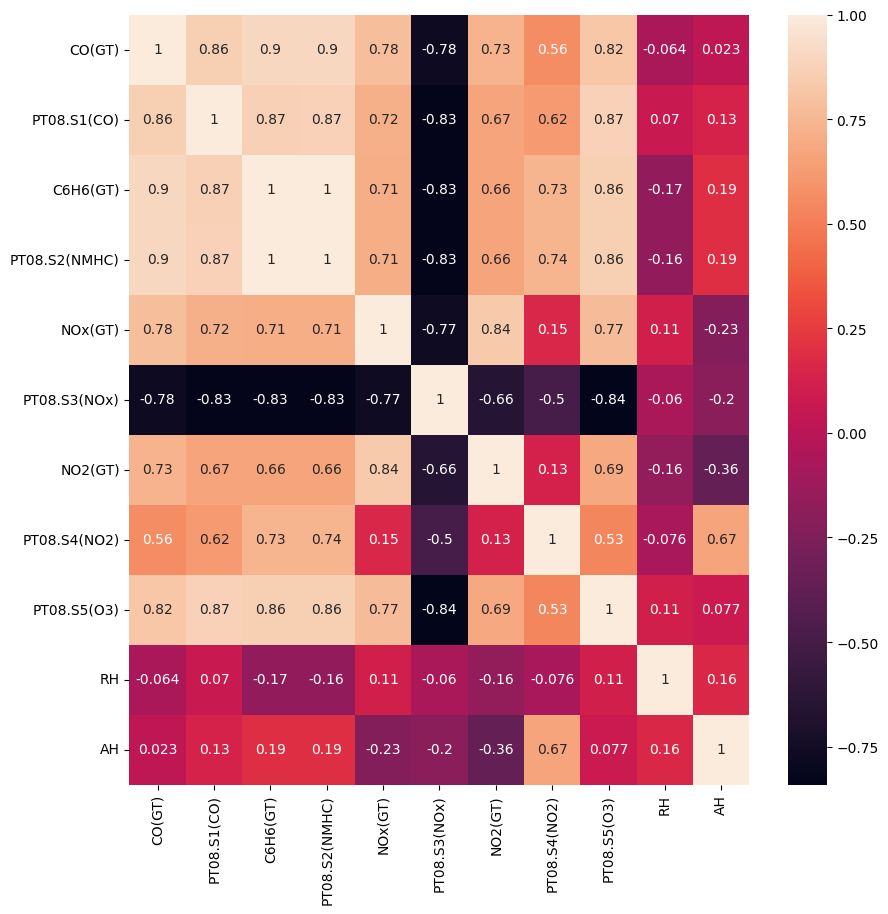

In [27]:
plt.figure(figsize = (10,10))
sns.heatmap( X.corr(), annot=True )

### Observation -> Problem: Here we can see the problem of multicollinearity.

<h3> &nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp
    -> Solution: We can drop all the features which are having high cor-relation with other independent variables.

### Here we are choosing 0.85 as the threshold for the multicollinearity.
### This means that, we are dropping the variables which are having the correlation > 0.85, with any of  the other independent varaiable.
    
### List of Variables with higher correlations (> 0.85):
    -> PT08.S1(CO) and PT08.S2(NMHC) -> 0.87
    -> PT08.S1(CO) and PT08.S5(O3) -> 0.87
    -> PT08.S1(CO) and C6H6(GT) -> 0.87

    -> C6H6(GT) and CO(GT) -> 0.9
    -> PT08.S2(NMHC) and CO(GT) -> 0.9
    -> PT08.S1(CO) and CO(GT) -> 0.86



### -> Hence we can drop `PT08.S2(NMHC)`, `PT08.S5(O3)`, `C6H6(GT)` and `CO(GT)`columns

In [28]:
X.drop(["PT08.S1(CO)", "PT08.S2(NMHC)", "PT08.S3(NOx)" ,"NO2(GT)"], axis=1, inplace=True)

<Axes: >

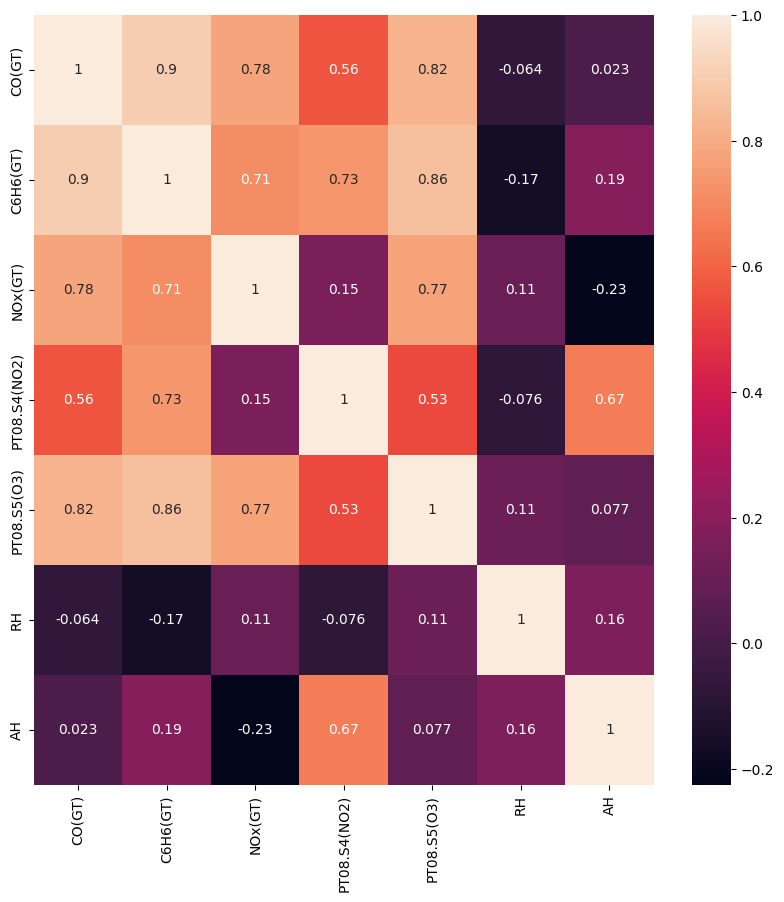

In [29]:
plt.figure(figsize = (10,10))
sns.heatmap( X.corr(), annot=True )

In [30]:
# final_cleaned_preprocessed_dataset = pd.concat([X, y], axis=1)
# final_cleaned_preprocessed_dataset.to_csv("final_cleaned_preprocessed_dataset.csv", encoding="utf-8", index=False)

Feature Selection using lasso (L1)

In [31]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting Lasso Regression
lasso = Lasso(alpha=0.1)  # Regularization strength
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [32]:
selected_features = X.columns[lasso.coef_ != 0]  # Non-zero coefficients
removed_features = X.columns[lasso.coef_ == 0]  # Zero coefficients

In [33]:
removed_features

Index(['C6H6(GT)'], dtype='object')

In [34]:
selected_features

Index(['CO(GT)', 'NOx(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'RH', 'AH'], dtype='object')

In [35]:
X.drop(list(removed_features), axis=1, inplace=True)


### Finally we are having a cleaned dataset

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

class Apply_Regression:
    def __init__(self,
                 X,
                 y,
                 test_size,
                 random_state=42,
                 regression_models=None,
                 cv_folds=5,
                ):

        self.X, self.y = X, y
        self.test_size = test_size
        self.random_state = random_state
        self.regression_models = regression_models if regression_models is not None else [
            RandomForestRegressor(random_state=random_state),
            LinearRegression(),
            SVR(),
            KNeighborsRegressor(),
            DecisionTreeRegressor(random_state=random_state),
            xgb.XGBRegressor(random_state=random_state),
            lgb.LGBMRegressor(random_state=random_state, verbose=-1)
        ]
        self.cv_folds = cv_folds
        self.model = None

    def apply_train_test_split(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state = self.random_state)
        return X_train, X_test, y_train, y_test

    def model_evaluation(self, X_train, X_test, y_train, y_test):
        """
        Evaluate model performance on the training and testing data.
        """

        y_pred = self.model.predict(X_test)
        y_pred_train = self.model.predict(X_train)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        r2_train = r2_score(y_train, y_pred_train)

        return {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'R2_train': r2_train
        }

    def perform_hyperparameter_tuning(self, model, X_train, y_train):
        """
        Perform GridSearchCV for hyperparameter tuning on the given model.
        """
        if isinstance(model, RandomForestRegressor):
            param_grid = {
                'n_estimators': [50, 100, 200],  # Number of trees in the forest.
                'max_depth': [None, 10, 20],  # Maximum depth of each tree.
                'min_samples_split': [2, 10],  # Minimum number of samples required to split a node.
                'min_samples_leaf': [1, 2]  # Minimum number of samples required to be at a leaf node.
            }
        elif isinstance(model, SVR):
            param_grid = {
                'C': [0.1, 10],  # Regularization parameter controlling trade-off between smoothness and accuracy.
                'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid' kernels.
                'kernel': ['rbf', 'sigmoid']  # Specifies the kernel type to be used.
            }
        elif isinstance(model, KNeighborsRegressor):
            param_grid = {
                'n_neighbors': [3, 5, 7, 9],  # Number of neighbors to use for prediction.
                'weights': ['uniform', 'distance'],  # Weight function for the neighbor contributions.
                'algorithm': ['auto', 'ball_tree', 'kd_tree']  # Algorithm used to compute nearest neighbors.
            }
        elif isinstance(model, DecisionTreeRegressor):
            param_grid = {
                'max_depth': [None, 10, 20],  # Maximum depth of the tree.
                'min_samples_split': [2, 5],  # Minimum number of samples required to split a node.
                'min_samples_leaf': [2, 4]  # Minimum number of samples required to be at a leaf node.
            }
        elif isinstance(model, xgb.XGBRegressor):
            param_grid = {
                'n_estimators': [200, 300, 500],  # Number of boosting rounds.
                'max_depth': [ 7, 10, 12],  # Maximum depth of a tree.
                'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage used in updates to prevent overfitting.
                'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for training each tree.
            }
        elif isinstance(model, lgb.LGBMRegressor):
            param_grid = {
                'n_estimators': [200, 300],  # Number of boosting rounds.
                'learning_rate': [0.01, 0.05, 0.1],  # Learning rate for boosting.
                'max_depth': [3, 5, 7],  # Maximum depth of a tree.
                'num_leaves': [15, 31],  # Maximum number of leaves per tree.
                'min_data_in_leaf': [10, 20],  # Minimum number of data points in a leaf.
                'feature_fraction': [0.6, 0.8]  # Fraction of features used for each iteration.
            }
        else:
            param_grid = {}

        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=self.cv_folds, scoring='neg_mean_squared_error') #n_jobs=-1
        grid_search.fit(X_train.reset_index(drop=True).values, y_train.reset_index(drop=True).values)

        return grid_search.best_estimator_

    def run(self):
        """
        Run the entire AutoML pipeline.
        """
        X_train, X_test, y_train, y_test=  self.apply_train_test_split(self.X, self.y)

        best_model = None
        best_score = float('inf')
        results = {}

        for model in self.regression_models:
            print(f"Training {model.__class__.__name__}...")

            self.model = self.perform_hyperparameter_tuning(model, X_train, y_train)

            joblib.dump(self.model, "{}.pkl".format(model.__class__.__name__))

            evaluation_metrics = self.model_evaluation(X_train, X_test, y_train, y_test)
            results[model.__class__.__name__] = evaluation_metrics
            print("Performance: {}: {}".format(model.__class__.__name__, round( evaluation_metrics["R2"], 4)) )

            if evaluation_metrics['RMSE'] < best_score:
                best_score = evaluation_metrics['RMSE']
                best_model = model

        print("\nBest Model Performance (Lowest RMSE):")
        print(f"Model: {best_model.__class__.__name__}")
        print(results[best_model.__class__.__name__])

        return best_model, results

In [44]:
# Instantiate the AutoMLRegression class
regression_pipeline = Apply_Regression(
                 X,
                 y,
                 test_size=0.2,
                 random_state=30,
                 cv_folds=5,
)

# Run the AutoML pipeline
best_model, model_results = regression_pipeline.run()

# Print results
print("\nBest Model:")
print(best_model)
print("\nModel Results:")
for model_name, metrics in model_results.items():
    print(f"{model_name}: {metrics}")


Training XGBRegressor...
Performance: XGBRegressor: 0.7413
Training LGBMRegressor...
Performance: LGBMRegressor: 0.6861

Best Model Performance (Lowest RMSE):
Model: XGBRegressor
{'MAE': 7.120473517848365, 'MSE': 537.4287991378102, 'RMSE': 23.18251063059845, 'R2': 0.7412762656321246, 'R2_train': 0.9774837281253486}

Best Model:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=Non

In [48]:
model_names = ["RandomForestRegressor", "LinearRegression", "SVR", "KNeighborsRegressor", "DecisionTreeRegressor", "XGBRegressor", "LGBMRegressor"]

all_models = {name: joblib.load(f"{name}.pkl") for name in model_names}

all_models

{'RandomForestRegressor': RandomForestRegressor(n_estimators=200, random_state=30),
 'LinearRegression': LinearRegression(),
 'SVR': SVR(C=10, gamma='auto'),
 'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=9, weights='distance'),
 'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=10, min_samples_leaf=2, random_state=30),
 'XGBRegressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi

In [53]:
final_results = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

for name, model in all_models.items():
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    r2_train = r2_score(y_train, y_pred_train)

    final_results[name] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'R2_train': r2_train
        }



In [59]:
final_results = pd.DataFrame(final_results).T
final_results

,MAE,MSE,RMSE,R2,R2_train
RandomForestRegressor,4.231127,266.173869,16.314836,0.845957,0.901964
LinearRegression,15.554408,1652.222107,40.647535,0.043806,0.041008
SVR,7.632689,1229.258140,35.060778,0.288589,0.259806
KNeighborsRegressor,2.708414,275.118530,16.586697,0.840780,0.899182
DecisionTreeRegressor,8.547370,828.184469,28.778194,0.520703,0.536156
XGBRegressor,3.385477,205.423297,14.332596,0.881115,0.934846
LGBMRegressor,7.277263,307.688315,17.541047,0.821931,0.866456


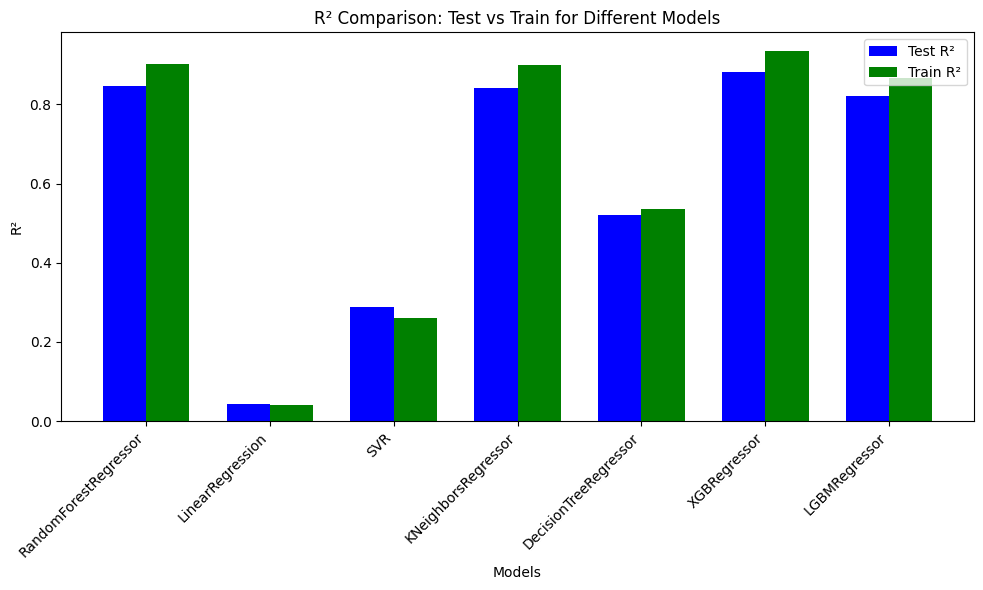

In [65]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Define the positions for the bars
x = np.arange(len(final_results))

# Plotting the bars for R2_test and R2_train
width = 0.35  # Width of the bars
plt.bar(x - width / 2, final_results['R2'], width, label='Test R²', color='blue')
plt.bar(x + width / 2, final_results['R2_train'], width, label='Train R²', color='green')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('R²')
plt.title('R² Comparison: Test vs Train for Different Models')
plt.xticks(x, final_results.index, rotation=45, ha='right')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Here we can see that XGBoost is giving the highest accuracy: 0.881115 <br>
With the following Parameters:
```Python
XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=30, ...),

    ```
